<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/CU/Lab4_Curie_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab4. Curie sets. Measurements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0 as mu0
from scipy.optimize import curve_fit
from scipy.stats import norm
import pandas as pd
import requests

# Resistance measurements

In [2]:
# Resistance measurements
url = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Curie/2025.09/R.txt'
devices, R1, R2 = np.loadtxt(url).T
print(f'Average R over {len(R1)} sets')
print(f'Measured  {np.mean(R1):.1f} ± {np.std(R1):.1f} Ohm,')
print(f'Measured  {np.mean(R2):.1f} ± {np.std(R2):.1f} Ohm')

Average R over 13 sets
Measured  11.0 ± 0.5 Ohm,
Measured  126.8 ± 5.1 Ohm


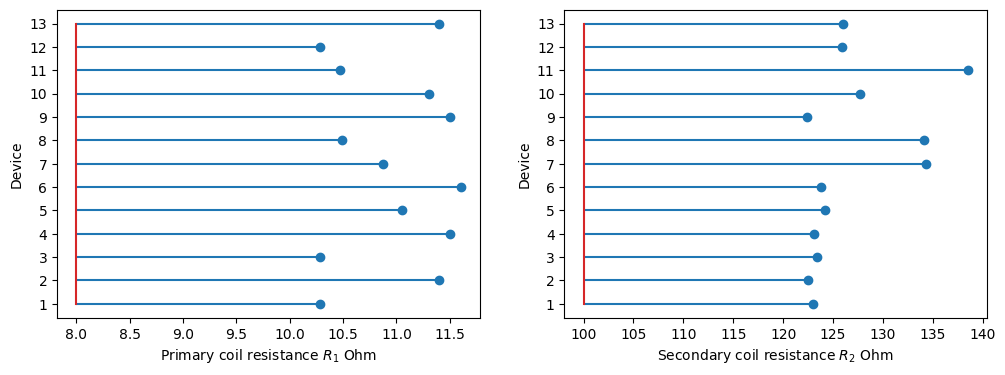

In [3]:
def makeplotR(axx, R, label, bottom):
  axx.set_yticks(devices)
  axx.stem(devices, R, orientation='horizontal', bottom=bottom)
  axx.set_xlabel(label)
  axx.set_ylabel('Device')

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
makeplotR(ax[0], R1, 'Primary coil resistance $R_1$ Ohm', bottom=8)
makeplotR(ax[1], R2, 'Secondary coil resistance $R_2$ Ohm', bottom=100)


#Inductance measurements

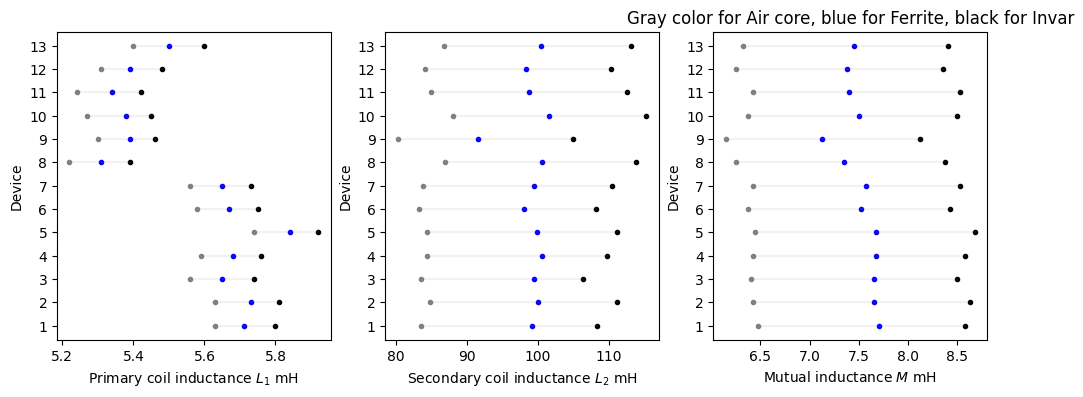

In [4]:

url = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Curie/2025.09/L.txt'

df = pd.read_csv(url, sep=r'\s+')

L1 =  df.pivot(index="#system", columns="sample", values="L1").to_numpy() * 1e-3
L2 =  df.pivot(index="#system", columns="sample", values="L2").to_numpy() * 1e-3
Lplus =  df.pivot(index="#system", columns="sample", values="Lplus").to_numpy() * 1e-3
Lminus =  df.pivot(index="#system", columns="sample", values="Lminus").to_numpy() * 1e-3
M = np.abs( Lplus - Lminus) / 4


def makeplotL(axx, L, label):
  axx.set_yticks(devices)
  axx.plot(L[:,0]*1e3, devices, '.', color='gray')
  axx.plot(L[:,1]*1e3, devices, '.', color='blue')
  axx.plot(L[:,2]*1e3, devices, '.', color='black')
  for device in [int(d) for d in devices]:
    ypoints = (device, device)
    xpoints = (L[device-1,0]*1e3, L[device-1,2]*1e3)
    axx.plot(xpoints, ypoints, alpha=0.1, color='gray')
  axx.set_xlabel(label)
  axx.set_ylabel('Device')

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

plt.title('Gray color for Air core, blue for Ferrite, black for Invar')
makeplotL(ax[0], L1, 'Primary coil inductance $L_1$ mH')
makeplotL(ax[1], L2, 'Secondary coil inductance $L_2$ mH')
makeplotL(ax[2], M , 'Mutual inductance $M$ mH')


## (EK)  Measuring mutual inductance $M$ directly

[source](https://www.uni-ruse.bg/disciplines/TE/Lecture%20notes/Lectures%20notes%20Mutually%20coupled%20inductors.pdf)

1. Measure each coil alone: $L_1$, $L_2$
2. Measure series-aiding connection $L_+$ (Expected $L_+ > L_1+L_2$).
3. Measure series-opposing connection $L_-$ (Expected $L_- < L_1+L_2$).
4. Compute $M$:
$$
M = \frac{L_+ + L_-}{4}
\tag{Mutual inductance}
$$


Transformation ratio between $V_P$ and $V_S$ using mutual inductance $M$ for open secondary coil

 Primary terminals $ V_P = (R_1 + j \omega L_1) I$

Secondary open $V_s = j\omega M I$.

Thus
$$
\frac{V_s}{V_p} = \frac{j \omega M}{R_1 + j \omega L_1}
\tag{Expected response}
$$

# Frequency response measurements

Gray points  -  air core.
Blue points  -  ferrite core.
Black points -  invar core.


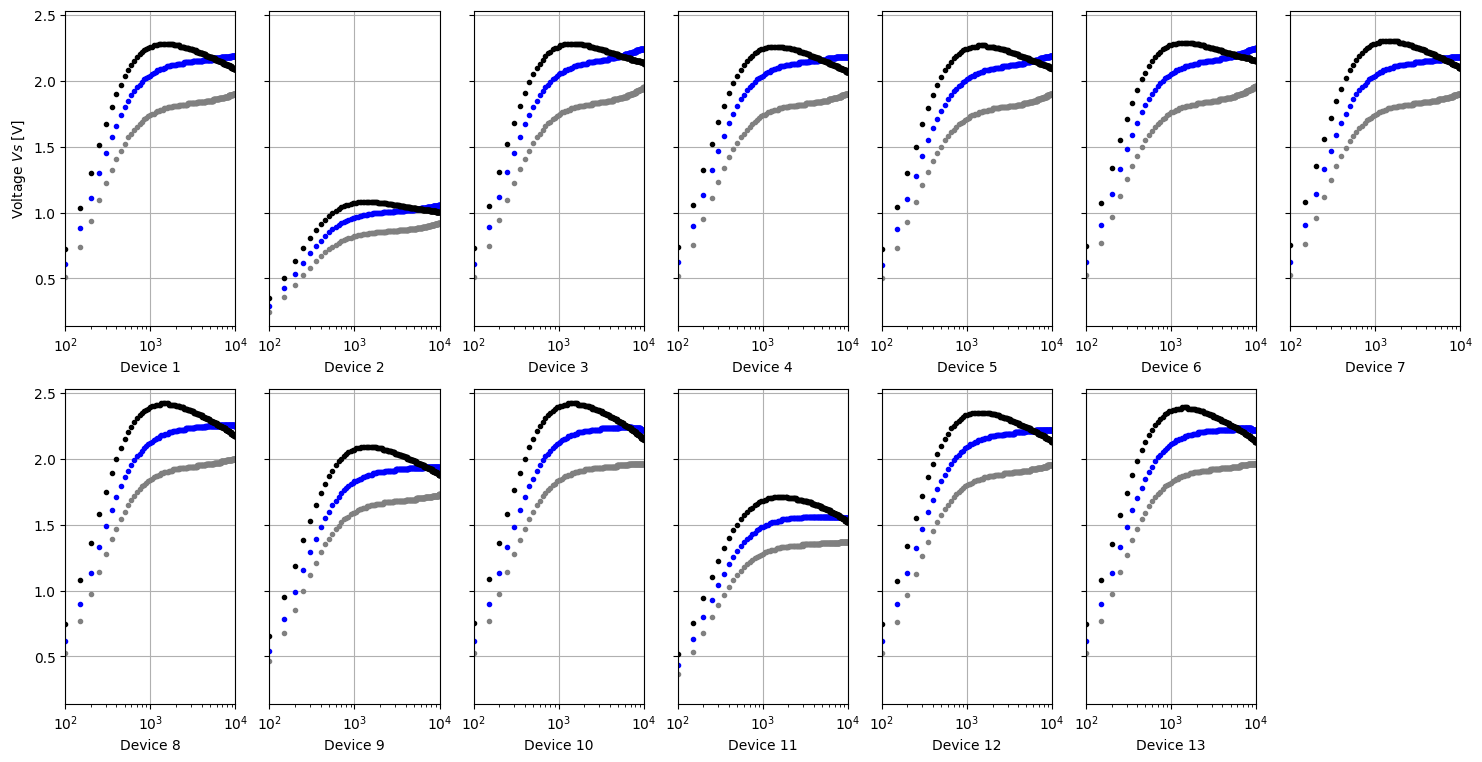

In [5]:
# frequency response measurements
URL = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Curie/2025.09/{name}_f.csv'
MAX_FREQ = 1e4
colors = ['gray', 'blue', 'black']

fig, ax = plt.subplots(2, 7, figsize=(18, 9), sharey=True)
for ix, name in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]):
  row = ix // 7
  col = ix % 7
  axx = ax[row, col]
  #axx = ax[ix]
  url = URL.format(name=name)
  f, Vs0, Vs1, Vs2 = np.loadtxt(url, skiprows=1, delimiter=',').T

  for core in [0, 1, 2]:
    if core == 0:
      Vs = Vs0
    elif core == 1:
      Vs = Vs1
    else:
      Vs = Vs2

    axx.plot(f, Vs, color=colors[core], marker='.', ls='')

    axx.set_xscale('log')
    axx.set_xlabel(f'Device {name}')
    if ix == 0:
      axx.set_ylabel(r'Voltage $Vs$ [V]')
    #axx.legend()
    axx.grid()
    #plt.title('Expected vs observed response for air core (0) and samples 1,2')
    axx.set_xlim(100, MAX_FREQ)

  ax[1, 6].axis('off')

print(f'Gray points  -  air core.')
print(f'Blue points  -  ferrite core.')
print(f'Black points -  invar core.')


# Set 13 frequency scan manually

(100, 50000.0)

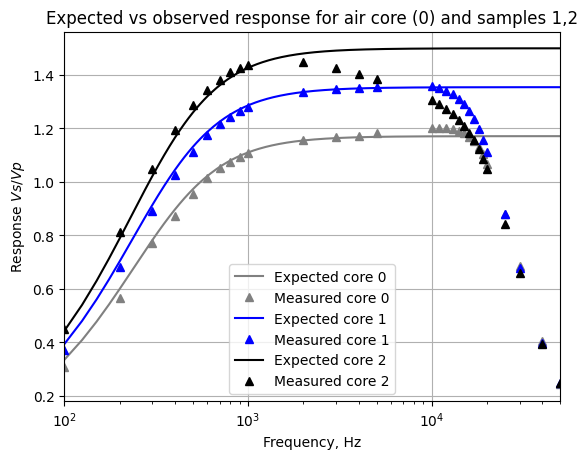

In [6]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab4/refs/heads/main/CU/frequency_scan_13.txt'
f, Vp, Vs0, Vs1, Vs2 = np.loadtxt(url).T
f *= 1e3 # -> Hz

MAX_FREQ = 50e3
device = 13

# expected
colors = ['gray', 'blue', 'black']
freqs = np.linspace(100, MAX_FREQ, 2000)
for core in [0, 1, 2]:
  M_  = M[device-1, core]
  L1_ = L1[device-1, core]
  R1_ = R1[device-1]
  ratio = [complex(0, omega * M_) / complex(R1_ , omega * L1_) for omega in 2*np.pi*freqs]

  plt.plot(freqs, np.abs(ratio), color=colors[core], label=f'Expected core {core}')
  if core == 0:
    Vs = Vs0
  elif core == 1:
    Vs = Vs1
  else:
    Vs = Vs2

  plt.plot(f, Vs/Vp, color=colors[core], marker='^', ls='',
           label=f'Measured core {core}')

plt.xscale('log')
plt.xlabel('Frequency, Hz')
plt.ylabel(r'Response $Vs/Vp$')
plt.legend()
plt.grid()
plt.title('Expected vs observed response for air core (0) and samples 1,2')

plt.xlim(100, MAX_FREQ)


# **Ferrite** core heating and cooling





In [7]:
def survival_function(x, height, loc, sigma, offset):
    return height * norm.sf(x, loc, sigma) + offset

def expected_response(device, sample, freq):
  ix = device - 1
  omega = 2 * np.pi * freq
  M_ = M[ix, sample]
  L1_ = L1[ix, sample]
  R1_ = R1[ix]
  Z = np.sqrt(R1_**2 + (omega * L1_)**2)
  ratio = omega * M_ / Z
  return ratio

def makeplotS(axx, name, core):
  try:
    temp, Vp, Vs, V_heater = np.loadtxt(url, delimiter=',', usecols=[1,2,3,5], skiprows=8, unpack=True)
    response = Vs / Vp
  except FileNotFoundError:
    print(f'File {url} not found. Skipping this.')
    return

  response = response[temp > MIN_TEMP]
  V_heater = V_heater[temp > MIN_TEMP]
  temp = temp[temp > MIN_TEMP]

  cooling = (V_heater == 0)
  temp_c = temp[cooling]
  response_c = response[cooling]

  # Fit the heating curve

  height = np.max(response) - np.min(response)
  offset = np.min(response)
  sigma = 10
  loc = np.max(temp) - sigma
  initial = [height, loc, sigma, offset]

  # Fit the cooling curve
  popt,  _ = curve_fit(survival_function, temp_c, response_c, p0=initial)


  Tc, Tc_sigma = popt[1], popt[2]
  axx.plot(temp, response, color='gray', marker='.')

  axx.plot(temp_c, survival_function(temp_c, *popt), ls='-', color='green',
          label=rf'{Tc:.0f} ± {Tc_sigma:.0f} °C')
  axx.legend(loc='lower center')
  axx.axhline(expected_response(name, core, freq), color='red')
  axx.axhline(expected_response(name, 0, freq), color='black')
  axx.grid()
  axx.set_xlabel(f'Device {name}')
  axx.set_ylim(1.00, MAX_RESPONSE)
  axx.set_xlim(MIN_TEMP, MAX_TEMP)
  axx.set_ylabel('Response Vs/Vp')


Red line - expected response for ferrite core at room temperature and frequency 1 kHz
Black line - expected response for air core at room temperature and frequency 1 kHz
Green line - survival function fit of measurements at cooling part of the experiment.


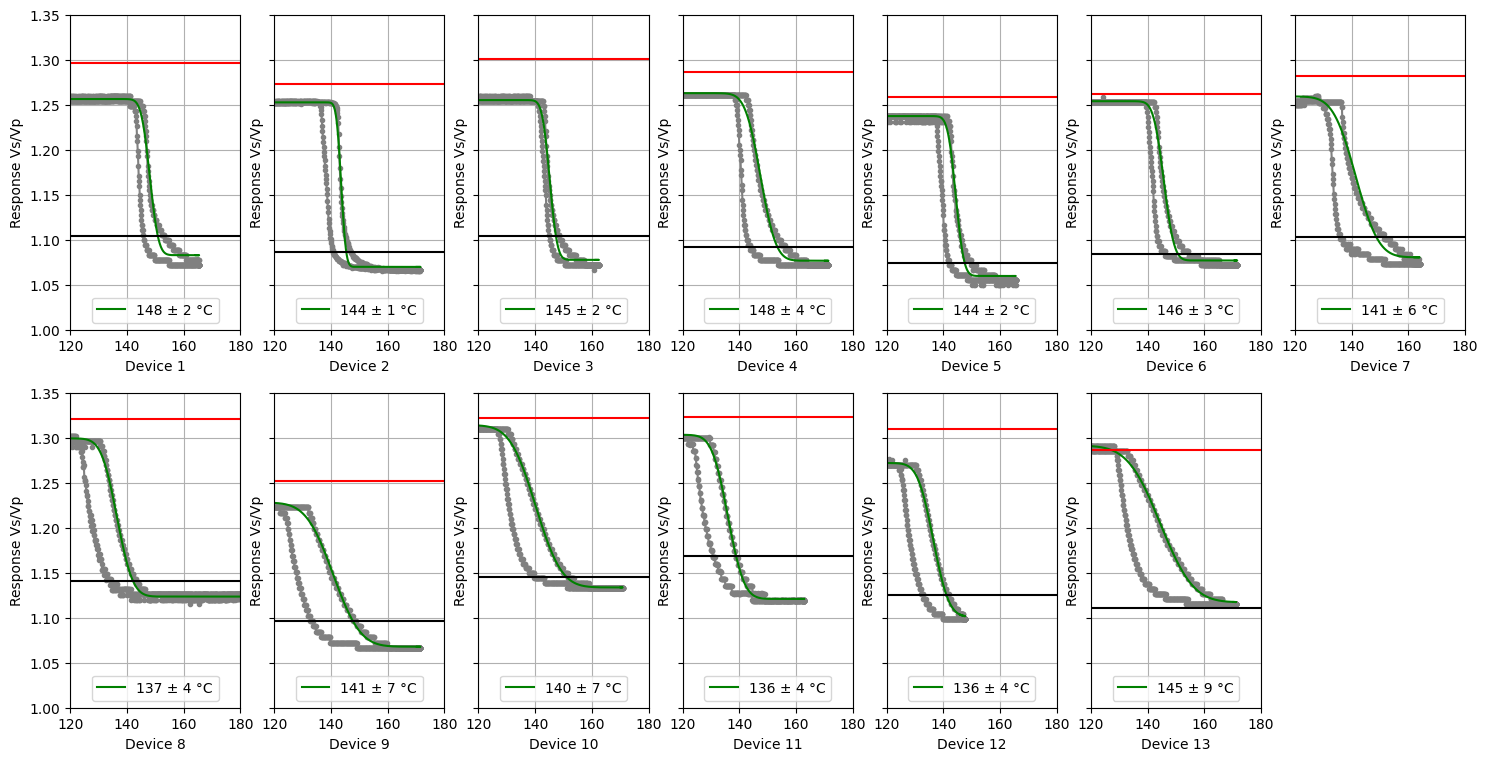

In [8]:
URL = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Curie/2025.09/{name}_1.csv'
MIN_TEMP = 120
MAX_TEMP = 180
MAX_RESPONSE = 1.35
freq = 1000 # Hz
core = 1

fig, ax = plt.subplots(2, 7, figsize=(18, 9), sharey=True)
for ix, name in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]):
  row = ix // 7
  col = ix % 7
  axx = ax[row, col]
  #axx = ax[ix]
  url = URL.format(name=name)
  makeplotS(axx, name, core)
ax[1, 6].axis('off')

print(f'Red line - expected response for ferrite core at room temperature and frequency {freq*1e-3:.0f} kHz')
print(f'Black line - expected response for air core at room temperature and frequency {freq*1e-3:.0f} kHz')
print(f'Green line - survival function fit of measurements at cooling part of the experiment.')

# **Invar** core heating and cooling





Red line - expected response for invar core at room temperature and frequency 1 kHz
Black line - expected response for air core at room temperature and frequency 1 kHz
Green line - survival function fit of measurements at cooling part of the experiment.


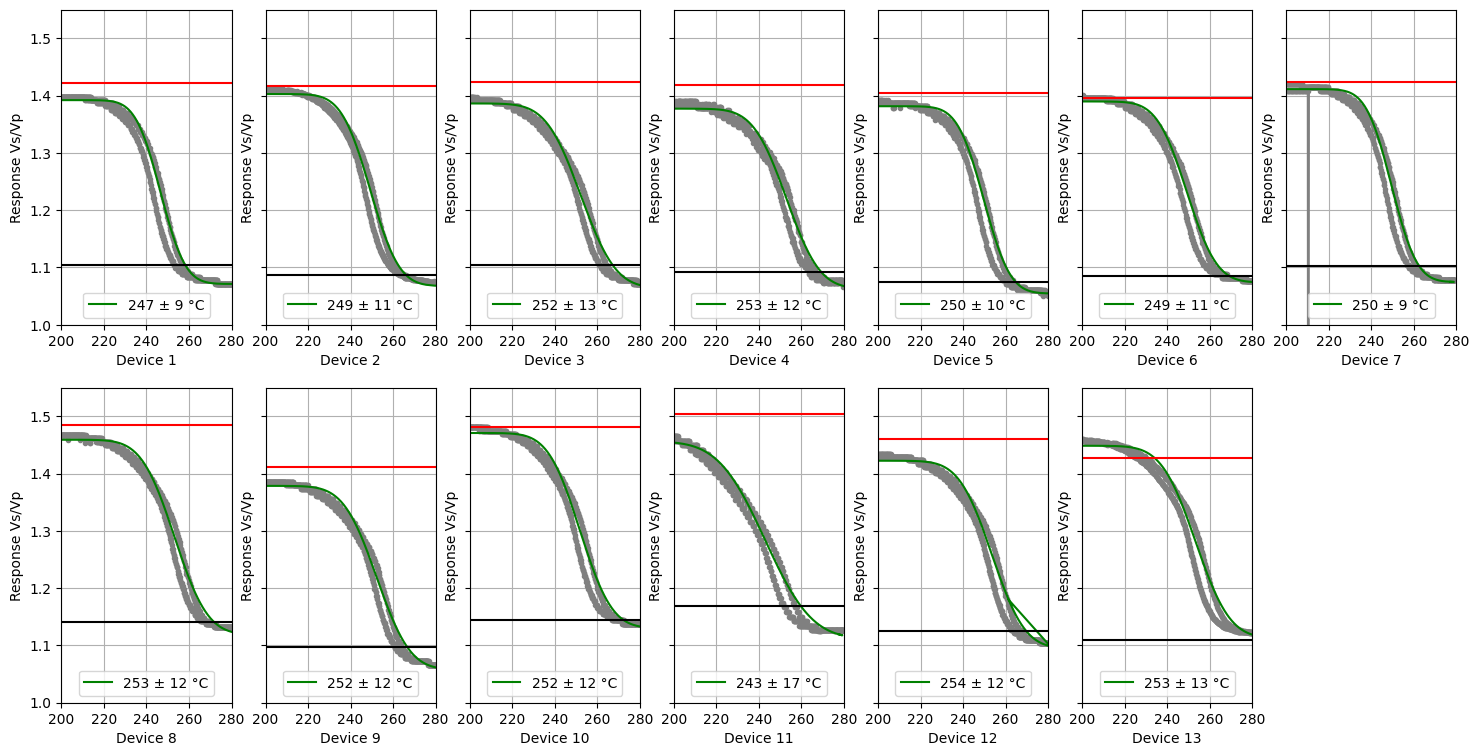

In [9]:
URL = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Curie/2025.09/{name}_2.csv'
MIN_TEMP = 200
MAX_TEMP = 280
MAX_RESPONSE = 1.55
freq = 1000 # Hz
core = 2

fig, ax = plt.subplots(2, 7, figsize=(18, 9), sharey=True)
for ix, name in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]):
  row = ix // 7
  col = ix % 7
  axx = ax[row, col]
  #axx = ax[ix]
  url = URL.format(name=name)
  makeplotS(axx, name, core)
ax[1, 6].axis('off')

print(f'Red line - expected response for invar core at room temperature and frequency {freq*1e-3:.0f} kHz')
print(f'Black line - expected response for air core at room temperature and frequency {freq*1e-3:.0f} kHz')
print(f'Green line - survival function fit of measurements at cooling part of the experiment.')